# Monthly Climatology of EKE in NATL
$\frac{1}{2}(U^{'2} + V^{'2})$

CESM

In [24]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [25]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ec4f914c52a5437a8aa900b57b81a111/status,


In [116]:
client.close()
cluster.close()

In [52]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import json
import fsspec
import gcsfs
import gcm_filters
import pop_tools
import gsw

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'KMT', 'TAREA',
                                                         'HUS', 'HTE','HTN', 'HUW', 'time']])

## MASK

In [8]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [9]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [10]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

In [11]:
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))

### Significant difference in 1 & 2

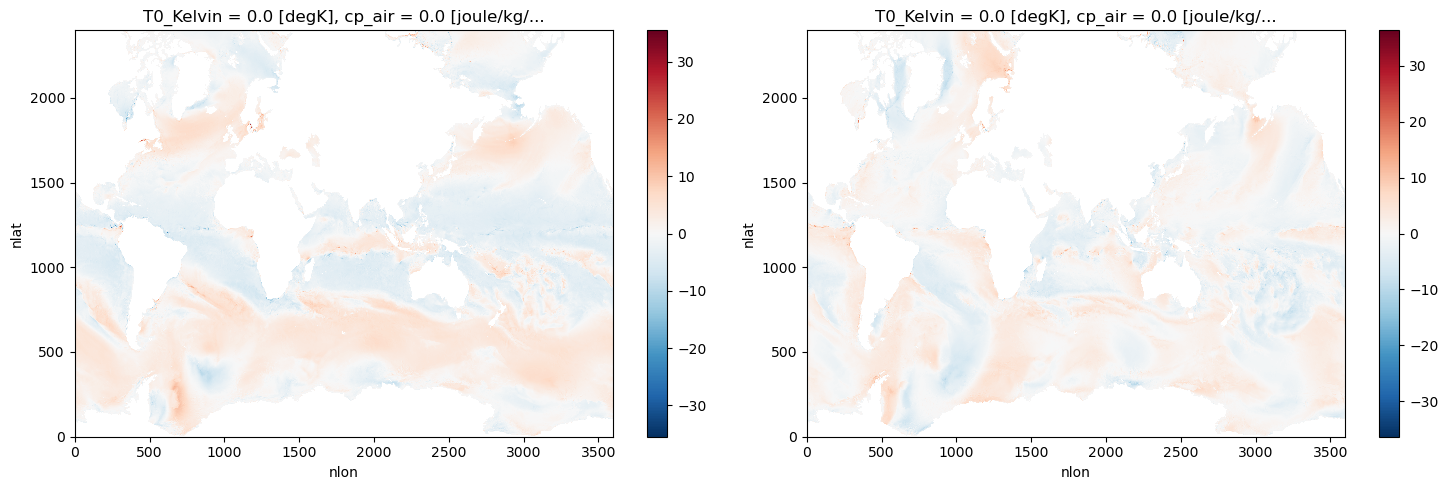

In [29]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,5))
(cesm.U1_1[0] - cesm.U2_2[0]).plot(ax=ax0)
(cesm.V1_1[0] - cesm.V2_2[0]).plot(ax=ax1)
plt.tight_layout();

## Rho contour

In [53]:
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')
delta_rho = 0.1
rho_bins = np.arange(15, 35, delta_rho)

In [54]:
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))
rho_gb = rho.where(atl_mask).isel(**selection).groupby('time.month').mean('time')

## 1_1

In [38]:
up1 = (cesm.U1_1.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.U1_1.where(atl_mask).isel(**selection).groupby('time.month'))
vp1 = (cesm.V1_1.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.V1_1.where(atl_mask).isel(**selection).groupby('time.month'))

Task exception was never retrieved
future: <Task finished name='Task-6244' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2212> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2221, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-6245' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2212> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2221, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-6246' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pyth

In [39]:
eke1 = 0.5 * (up1**2 + vp1**2)

In [40]:
eke1_clim = eke1.groupby('time.month').mean('time')

In [41]:
eke1_clim

<xarray.DataArray (month: 12, nlat: 2200, nlon: 1500)>
dask.array<transpose, shape=(12, 2200, 1500), dtype=float32, chunksize=(1, 2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/22)
    ANGLE        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ANGLET       (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...           ...
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    UAREA        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

## 2_2

In [42]:
up2 = (cesm.U2_2.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.U2_2.where(atl_mask).isel(**selection).groupby('time.month'))
vp2 = (cesm.V2_2.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.V2_2.where(atl_mask).isel(**selection).groupby('time.month'))

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [43]:
eke2 = 0.5 * (up2**2 + vp2**2)

In [44]:
eke2_clim = eke2.groupby('time.month').mean('time')

In [45]:
eke2_clim

<xarray.DataArray (month: 12, nlat: 2200, nlon: 1500)>
dask.array<transpose, shape=(12, 2200, 1500), dtype=float32, chunksize=(1, 2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/22)
    ANGLE        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ANGLET       (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...           ...
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    UAREA        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

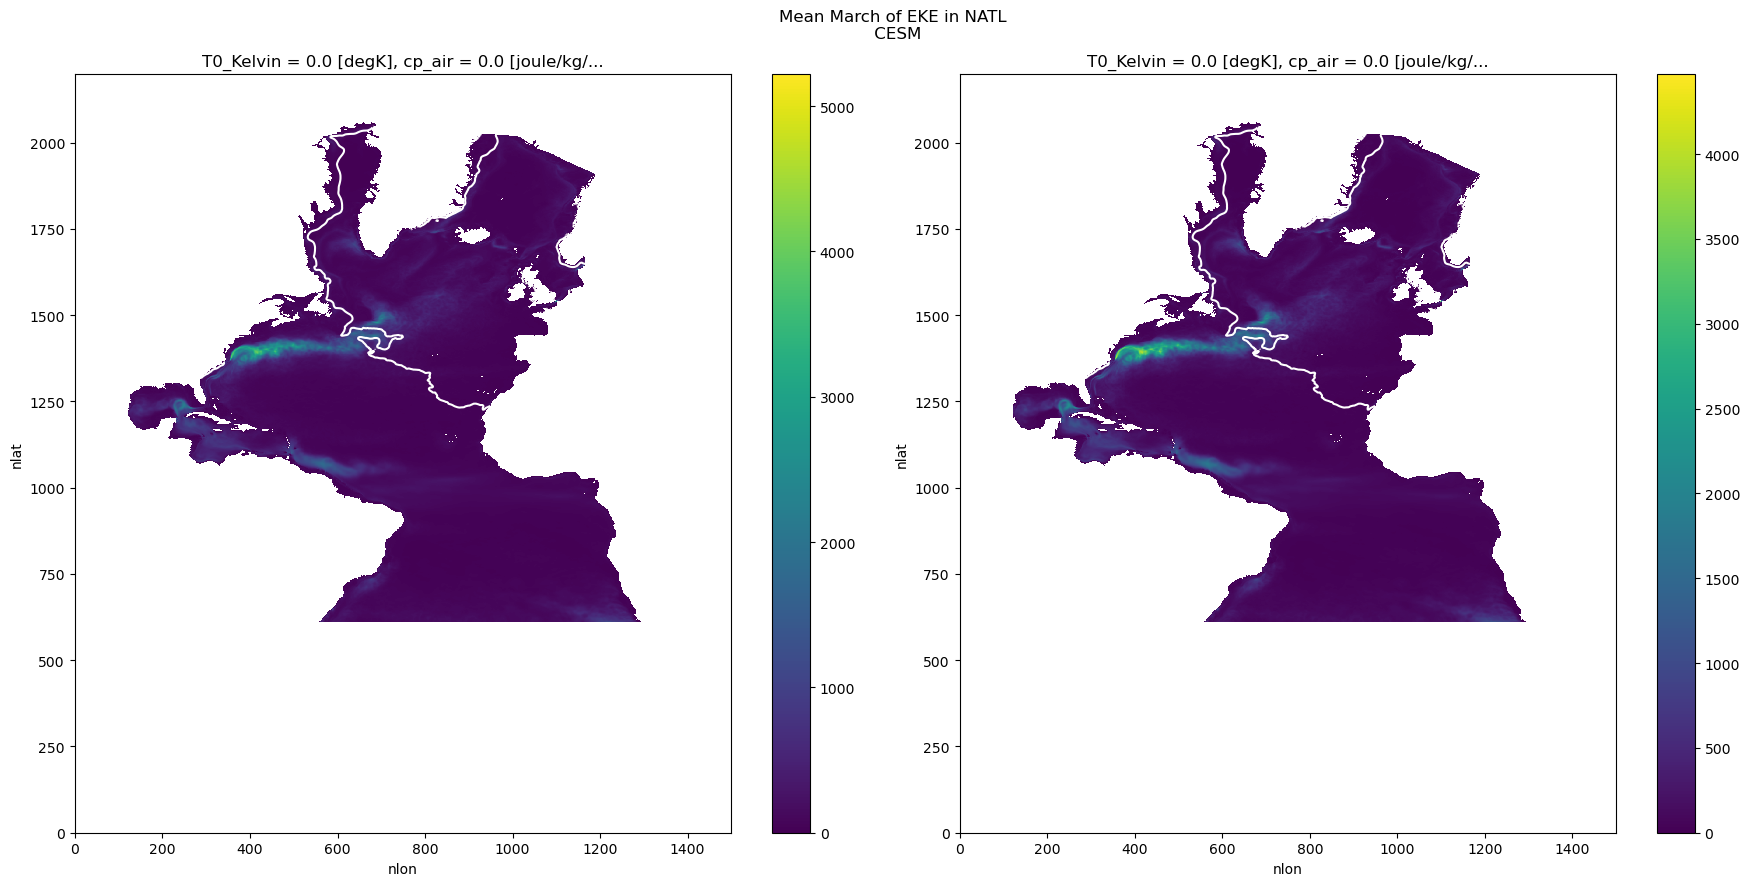

In [55]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(18,9))

eke1_clim.sel(month=3).plot(ax=ax0)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[113]], ax=ax0)

c = eke2_clim.sel(month=3).plot(ax=ax1)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[113]], ax=ax1)

#plt.colorbar(c, ax=ax1, label=r'[cm^2 s$^{-1}$]')
plt.suptitle('Mean March of EKE in NATL \n CESM')
plt.tight_layout();

# RMS for MARCH
the square root of the mean of the squared values of elements of y in $y = m(x) + b$

## 1_1

In [48]:
eke1_rms = (eke1_clim.sel(month=3))**0.5
eke2_rms = (eke2_clim.sel(month=3))**0.5

In [49]:
eke1_rms

<xarray.DataArray (nlat: 2200, nlon: 1500)>
dask.array<pow, shape=(2200, 1500), dtype=float32, chunksize=(2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/22)
    ANGLE        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ANGLET       (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...           ...
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    UAREA        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    month        int64 3
Dimensions without coordinates: nlat, nlon

Task exception was never retrieved
future: <Task finished name='Task-6643' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2212> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2221, in wait
    raise AllExit()
distributed.client.AllExit


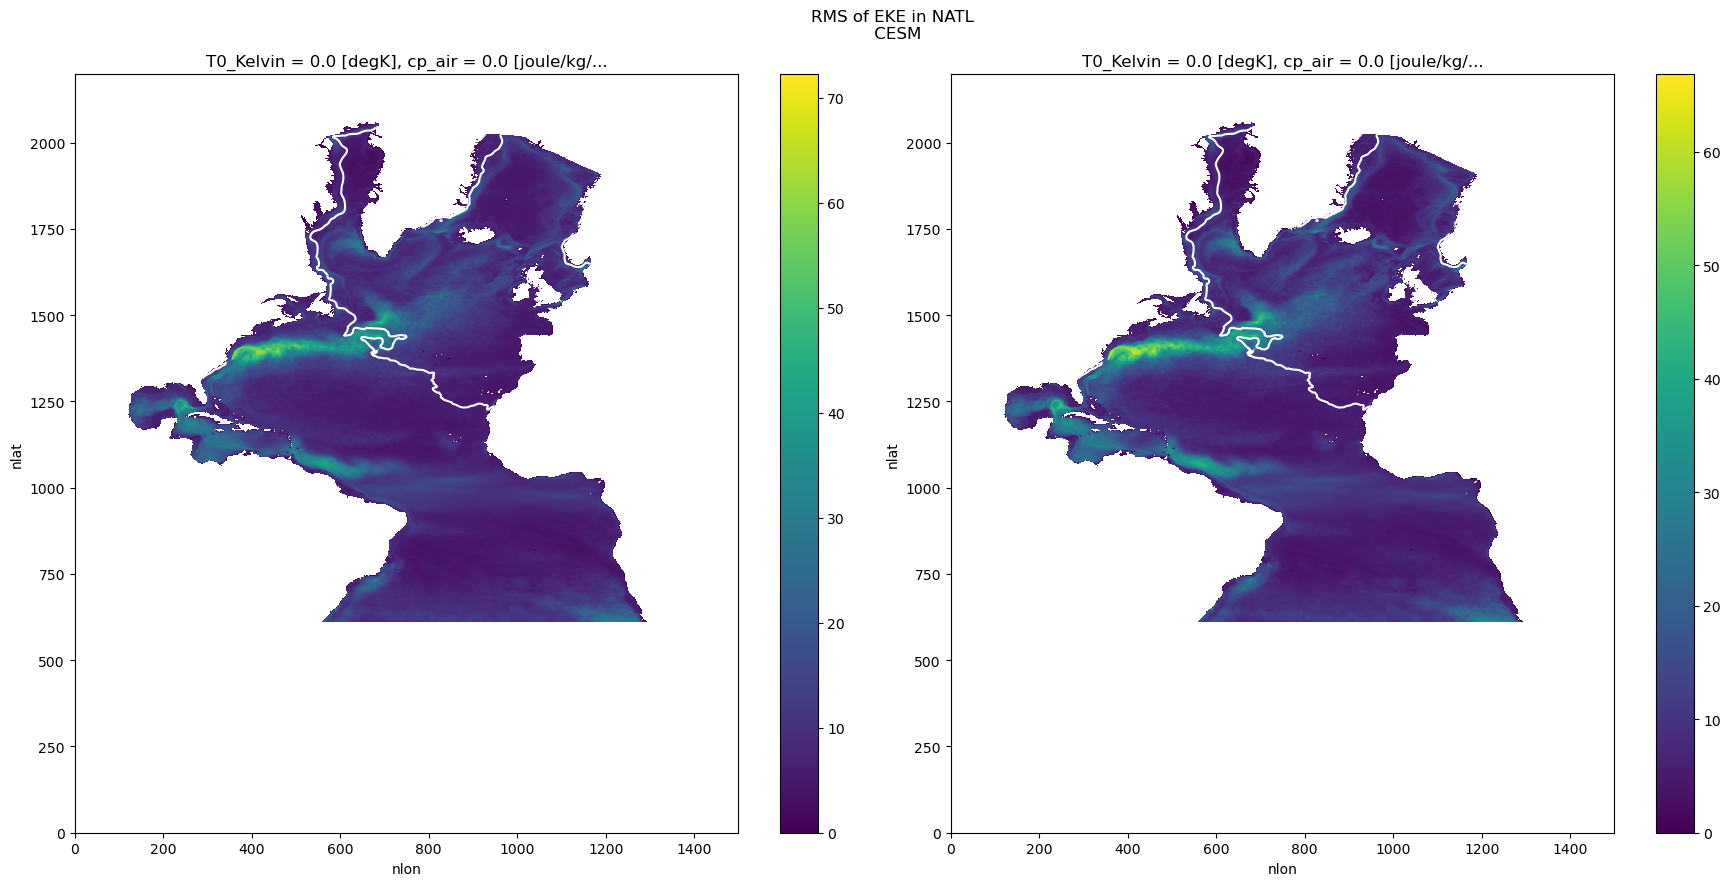

In [57]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(18,9))

eke1_rms.plot(ax=ax0)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[113]], ax=ax0)

eke2_rms.plot(ax=ax1)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[113]], ax=ax1)

plt.suptitle('RMS of EKE in NATL \n CESM')
plt.tight_layout();